<a href="https://colab.research.google.com/github/utkarsh-prakash/Anamoly-Detection/blob/main/Anomaly_Detection_using_timeseries_modeling_and_isolation_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
import pandas as pd
import plotly.express as px
from sklearn.ensemble import IsolationForest

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv')
df['timestamp']=pd.to_datetime(df['timestamp'])
df=df.set_index('timestamp').resample("H").mean().reset_index()
df

,timestamp,value
0,2014-07-01 00:00:00,9485.5
1,2014-07-01 01:00:00,5433.0
2,2014-07-01 02:00:00,3346.5
3,2014-07-01 03:00:00,2216.5
4,2014-07-01 04:00:00,2189.5
...,...,...
5155,2015-01-31 19:00:00,28288.5
5156,2015-01-31 20:00:00,24138.0
5157,2015-01-31 21:00:00,24194.5
5158,2015-01-31 22:00:00,26515.0


In [3]:
import tensorflow as tf
print(tf.__version__)

2.4.1


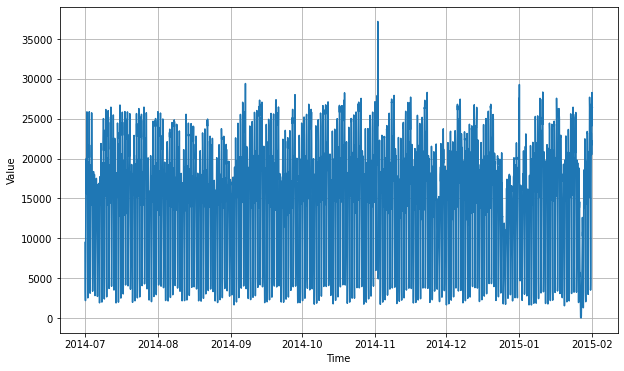

In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

plt.figure(figsize=(10, 6))
plot_series(df['timestamp'], df['value'])

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [6]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [7]:
time = np.array(df['timestamp'])
series = np.array(df['value'])
len(df)

5160

In [8]:
split_time = 4992
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 48
batch_size = 100
shuffle_buffer_size = 1000


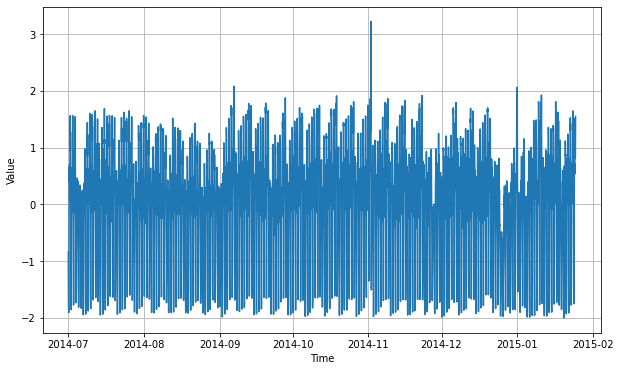

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train[:, np.newaxis])
x_train_scaled = x_train_scaled[:, -1]
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train_scaled)

In [10]:
# class PrintWeights(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs=None):
#     print(model.layers[0].get_weights())                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
# print_weights = PrintWeights()

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train_scaled, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)


# model = tf.keras.models.Sequential([
#   tf.keras.layers.Conv1D(32, 10, input_shape=(window_size,1)),
#   tf.keras.layers.SimpleRNN(64, return_sequences=True),
#   tf.keras.layers.SimpleRNN(64, return_sequences=True),
#   tf.keras.layers.SimpleRNN(64, return_sequences=True),
#   tf.keras.layers.SimpleRNN(32),
#   tf.keras.layers.Dense(20),
#   tf.keras.layers.Dense(1)
# ])

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(32, 10, input_shape=(window_size,1)),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(32),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 39, 32)            352       
_________________________________________________________________
lstm (LSTM)                  (None, 39, 64)            24832     
_________________________________________________________________
lstm_1 (LSTM)                (None, 39, 64)            33024     
_________________________________________________________________
lstm_2 (LSTM)                (None, 39, 64)            33024     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 20)                660       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2

In [12]:
model.compile(loss=tf.keras.losses.Huber(delta=1.0),
              optimizer=tf.keras.optimizers.SGD(lr=0.01),
              metrics=["mae"])
history = model.fit(train_set,epochs=100, verbose=2)

Epoch 1/100
50/50 - 14s - loss: 0.4367 - mae: 0.8018
Epoch 2/100
50/50 - 7s - loss: 0.4284 - mae: 0.7865
Epoch 3/100
50/50 - 7s - loss: 0.4194 - mae: 0.7762
Epoch 4/100
50/50 - 7s - loss: 0.4077 - mae: 0.7611
Epoch 5/100
50/50 - 7s - loss: 0.3913 - mae: 0.7418
Epoch 6/100
50/50 - 7s - loss: 0.3681 - mae: 0.7164
Epoch 7/100
50/50 - 7s - loss: 0.3399 - mae: 0.6890
Epoch 8/100
50/50 - 7s - loss: 0.3142 - mae: 0.6687
Epoch 9/100
50/50 - 7s - loss: 0.2989 - mae: 0.6579
Epoch 10/100
50/50 - 7s - loss: 0.2918 - mae: 0.6527
Epoch 11/100
50/50 - 7s - loss: 0.2866 - mae: 0.6470
Epoch 12/100
50/50 - 7s - loss: 0.2815 - mae: 0.6413
Epoch 13/100
50/50 - 7s - loss: 0.2774 - mae: 0.6356
Epoch 14/100
50/50 - 7s - loss: 0.2728 - mae: 0.6297
Epoch 15/100
50/50 - 7s - loss: 0.2680 - mae: 0.6235
Epoch 16/100
50/50 - 7s - loss: 0.2637 - mae: 0.6172
Epoch 17/100
50/50 - 7s - loss: 0.2591 - mae: 0.6108
Epoch 18/100
50/50 - 7s - loss: 0.2545 - mae: 0.6042
Epoch 19/100
50/50 - 7s - loss: 0.2498 - mae: 0.5974
E

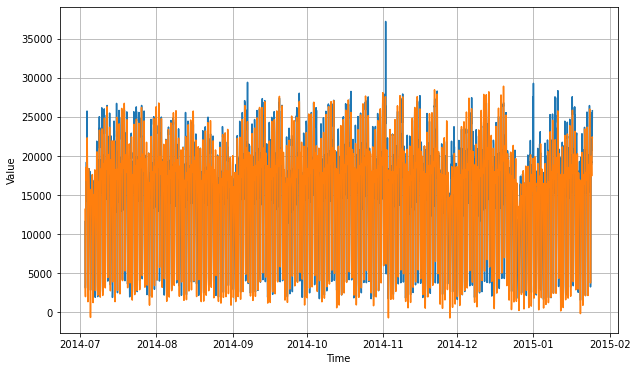

In [13]:
series_scaled = scaler.transform(series[:, np.newaxis])

forecast = model_forecast(model, series_scaled, window_size)

forecast = scaler.inverse_transform(forecast)[:,-1]
train_forecast = forecast[:split_time - window_size]
val_forecast = forecast[split_time - window_size:-1]

plt.figure(figsize=(10, 6))
plot_series(time_train[window_size:], x_train[window_size:])
plot_series(time_train[window_size:], train_forecast)

In [14]:
tf.keras.metrics.mean_absolute_error(x_train[window_size:],train_forecast).numpy()

1913.7993

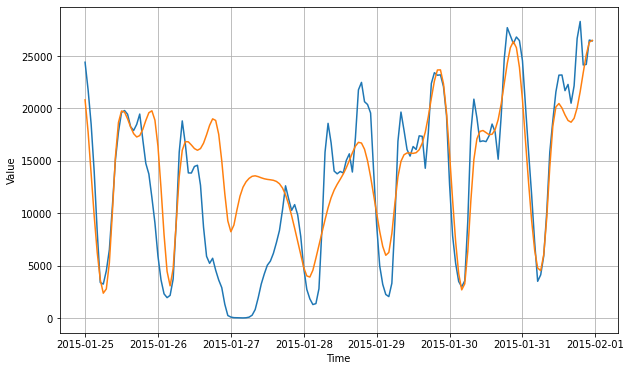

In [15]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, val_forecast)

In [16]:
tf.keras.metrics.mean_absolute_error(x_valid,val_forecast).numpy()

3589.2612

In [17]:
comparison_df = pd.DataFrame({'Time':time[window_size:], 'Actual':series[window_size:], 'Forecast': forecast[:-1]})
comparison_df

,Time,Actual,Forecast
0,2014-07-03 00:00:00,11604.0,13173.728516
1,2014-07-03 01:00:00,7757.0,8734.530273
2,2014-07-03 02:00:00,5104.5,5004.316895
3,2014-07-03 03:00:00,3109.0,2526.031738
4,2014-07-03 04:00:00,3111.5,1997.110718
...,...,...,...
5107,2015-01-31 19:00:00,28288.5,21598.855469
5108,2015-01-31 20:00:00,24138.0,23401.490234
5109,2015-01-31 21:00:00,24194.5,25105.945312
5110,2015-01-31 22:00:00,26515.0,26309.179688


In [18]:
comparison_df['Error'] = abs(comparison_df['Actual']-comparison_df['Forecast'])
comparison_df

,Time,Actual,Forecast,Error
0,2014-07-03 00:00:00,11604.0,13173.728516,1569.728516
1,2014-07-03 01:00:00,7757.0,8734.530273,977.530273
2,2014-07-03 02:00:00,5104.5,5004.316895,100.183105
3,2014-07-03 03:00:00,3109.0,2526.031738,582.968262
4,2014-07-03 04:00:00,3111.5,1997.110718,1114.389282
...,...,...,...,...
5107,2015-01-31 19:00:00,28288.5,21598.855469,6689.644531
5108,2015-01-31 20:00:00,24138.0,23401.490234,736.509766
5109,2015-01-31 21:00:00,24194.5,25105.945312,911.445312
5110,2015-01-31 22:00:00,26515.0,26309.179688,205.820312


In [19]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(contamination=0.004)
model.fit(comparison_df[['Error']])

IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.004,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [20]:
comparison_df['Outliers']=pd.Series(model.predict(comparison_df[['Error']])).apply(lambda x:'Yes' if  x==-1 else 'No')
comparison_df[comparison_df['Outliers']=='Yes']

,Time,Actual,Forecast,Error,Outliers
432,2014-07-21 00:00:00,8228.5,20823.375000,12594.875000,Yes
433,2014-07-21 01:00:00,4875.5,18457.353516,13581.853516,Yes
768,2014-08-04 00:00:00,7889.0,20869.333984,12980.333984,Yes
769,2014-08-04 01:00:00,4831.0,18622.218750,13791.218750,Yes
937,2014-08-11 01:00:00,4934.5,18072.470703,13137.970703,Yes
1105,2014-08-18 01:00:00,4989.5,18459.218750,13469.718750,Yes
1273,2014-08-25 01:00:00,4513.0,18730.886719,14217.886719,Yes
2929,2014-11-02 01:00:00,37204.5,23360.972656,13843.527344,Yes
4207,2014-12-25 07:00:00,2833.0,15799.460938,12966.460938,Yes
4208,2014-12-25 08:00:00,3205.5,16523.386719,13317.886719,Yes


In [21]:
fig = px.scatter(comparison_df.reset_index(), x='Time', y='Actual', color='Outliers', title='NYC Taxi Demand')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="3y", step="year", stepmode="backward"),
            dict(count=3, label="5y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()